# Dependencias

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet


# Dataset

In [7]:
data = pd.read_csv("./empleo_nacion/empleos_bsas_202303300007.csv")

In [3]:
data.head()

,fecha,departamento,provincia,clase,puestos
0,2014-01-01,CABA,CABA,"Agricultura, ganadería, caza y servicios relac...",5443
1,2014-01-01,CABA,CABA,Silvicultura y explotación forestal,119
2,2014-01-01,CABA,CABA,Pesca y acuicultura,581
3,2014-01-01,CABA,CABA,Extracción de carbón y lignito,24
4,2014-01-01,CABA,CABA,Extracción de petróleo crudo y gas natural,4145


In [8]:
# cambiamos el campo fecha de str a datetime
data["fecha"] = data.fecha.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

# EDA

In [9]:
# Creamos un subset con los datos de CABA agrupando por fecha
data_caba = data.loc[data.provincia == "CABA"].groupby(by=["fecha","provincia"]).sum().reset_index()

Text(0, 0.5, 'Puestos de trabajo')

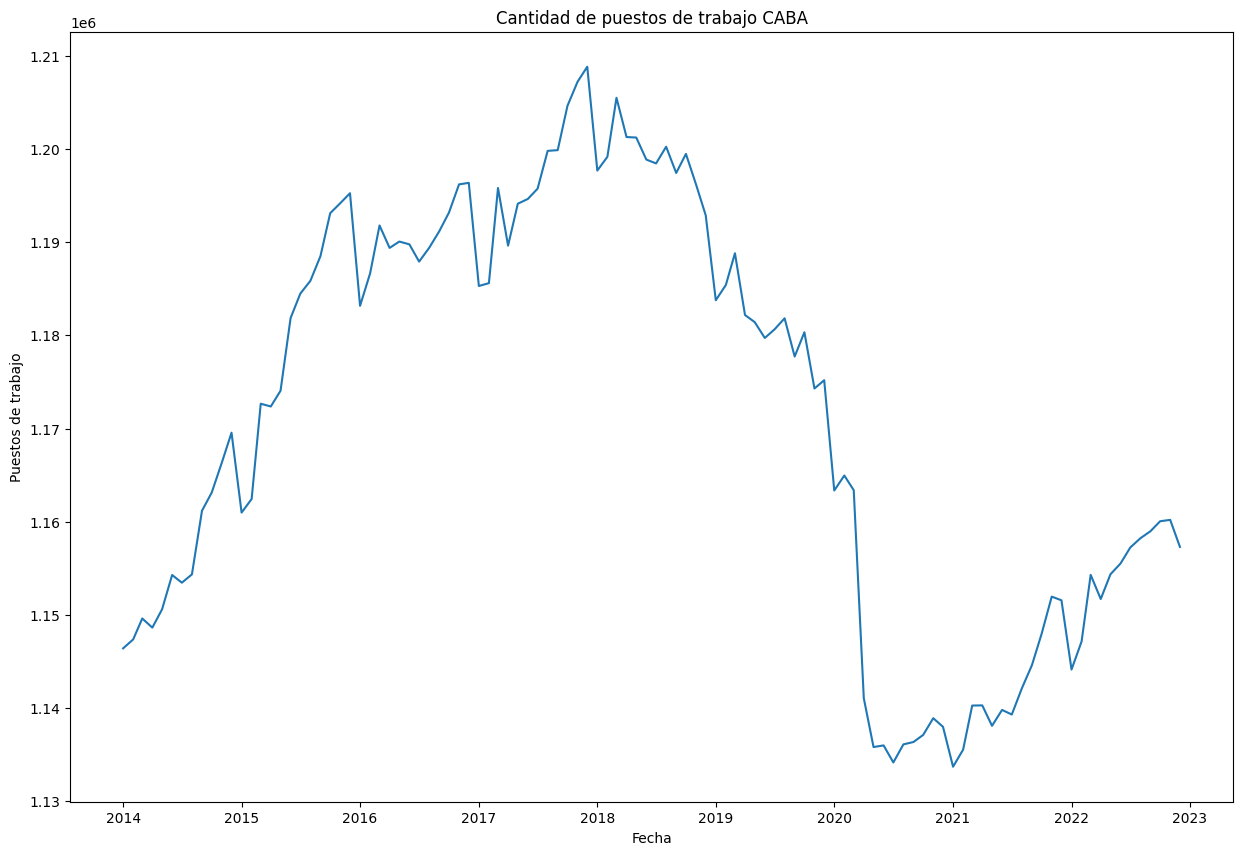

In [43]:
# Graficamos la serie de tiempo
plt.figure(figsize=(15, 10))
plt.plot(data_caba.fecha, data_caba.puestos)
plt.title('Cantidad de puestos de trabajo CABA')
plt.xlabel('Fecha')
plt.ylabel('Puestos de trabajo')

In [10]:
# Generamos subset de caba con el dato de cada sector o clase
data_caba_completo = data.loc[data.provincia == "CABA"]

In [11]:
# creamos una lista de sectores con mayor cantidad de puestos
top_sectore = data_caba_completo.groupby(by=["clase"]).sum().reset_index().sort_values("puestos", ascending = False).head(10).clase.to_list()

#Genero un subset para poder graficarlos
df_top_sectores = data_caba_completo[data_caba_completo.clase.isin(top_sectore)]

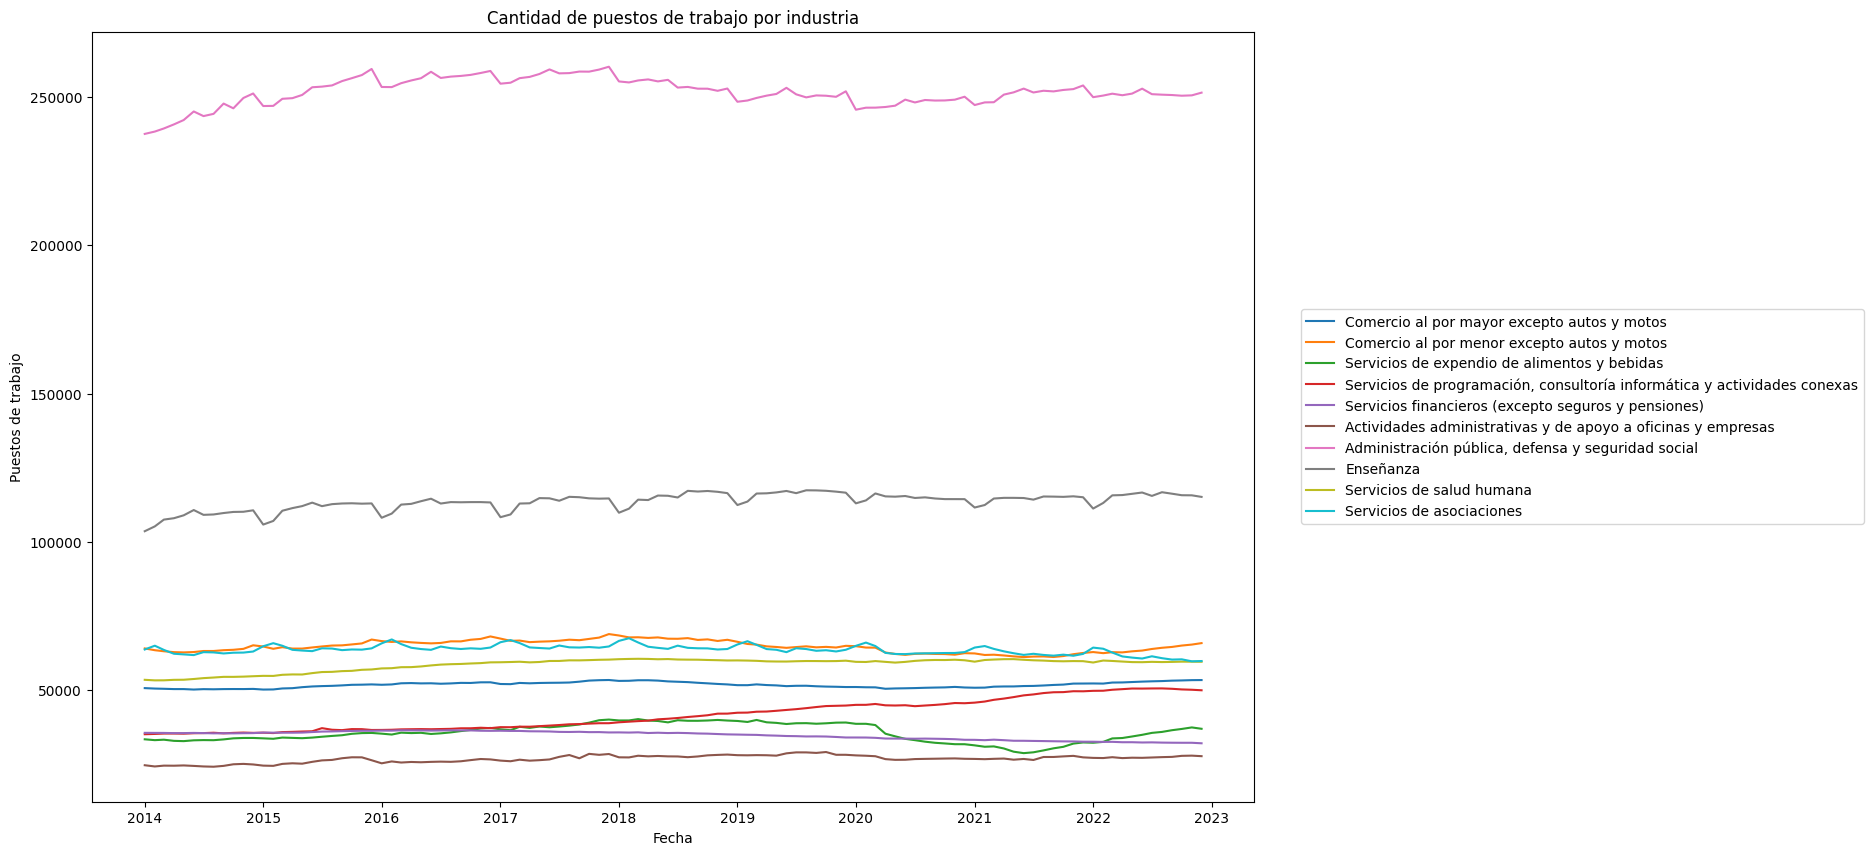

In [39]:
# Visualizar la serie de tiempo por sector
plt.figure(figsize=(15, 10))
sns.lineplot(x='fecha', y='puestos', hue='clase', data=df_top_sectores)
plt.title('Cantidad de puestos de trabajo por industria')
plt.xlabel('Fecha')
plt.ylabel('Puestos de trabajo')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()


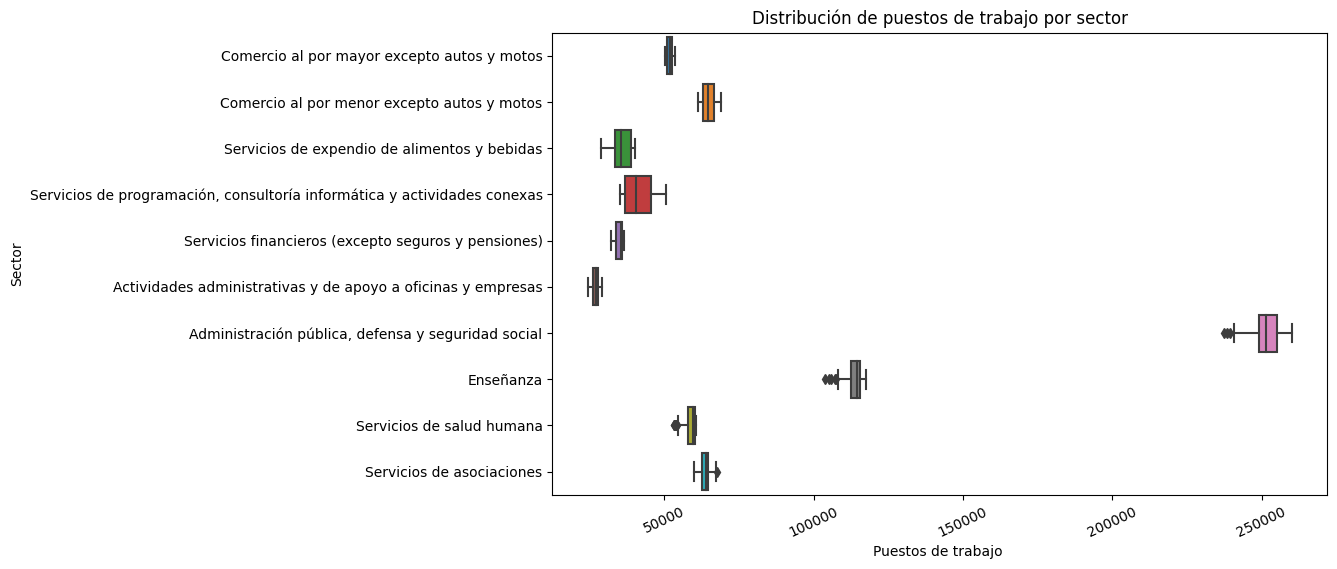

In [50]:
# Visualizo la distribución de puestos de trabajo por sector
plt.figure(figsize=(10, 6))
sns.boxplot(x='puestos', y='clase', data=df_top_sectores)
plt.title('Distribución de puestos de trabajo por sector')
plt.xlabel('Puestos de trabajo ')
plt.ylabel('Sector')
plt.xticks(rotation = 25) 
plt.show()

In [12]:
df_sector = df_top_sectores.groupby('clase').agg({'puestos': ['mean', 'median', 'min', 'max']})
df_sector.columns = ['Media', 'Mediana', 'Mínimo', 'Máximo']
df_sector

,Media,Mediana,Mínimo,Máximo
clase,,,,
Actividades administrativas y de apoyo a oficinas y empresas,26859.685185,26997.5,24220,29174
"Administración pública, defensa y seguridad social",251689.555556,251498.0,237558,260209
Comercio al por mayor excepto autos y motos,51805.685185,51841.0,50233,53456
Comercio al por menor excepto autos y motos,64761.879630,64687.5,61181,68936
Enseñanza,113544.064815,114431.0,103616,117412
Servicios de asociaciones,63653.518519,63888.0,59756,67543
Servicios de expendio de alimentos y bebidas,35644.342593,35558.0,28798,40274
"Servicios de programación, consultoría informática y actividades conexas",41638.805556,40520.0,35173,50622
Servicios de salud humana,58649.648148,59630.5,53335,60604


# Prophet

In [30]:
# Genero un nuevo subset para prophet, solo me tengo que quedar con dos columnas "ds" e "y"
data_prophet = data_caba.loc[data_caba["fecha"] < pd.to_datetime("2020-01-01").date() , ["fecha","puestos"]]
data_prophet.columns = ["ds", "y"]

23:19:17 - cmdstanpy - INFO - Chain [1] start processing
23:19:18 - cmdstanpy - INFO - Chain [1] done processing


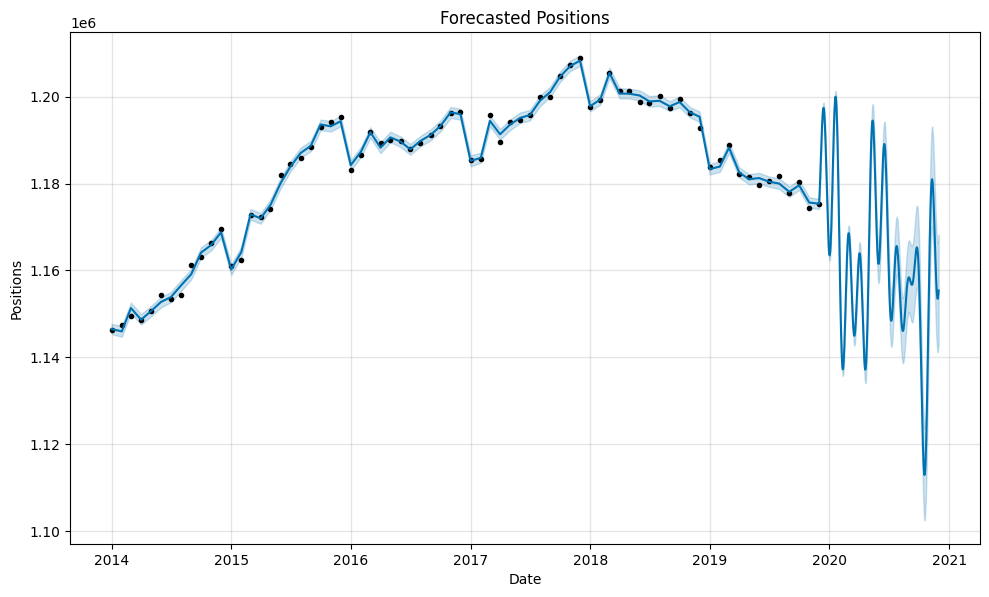

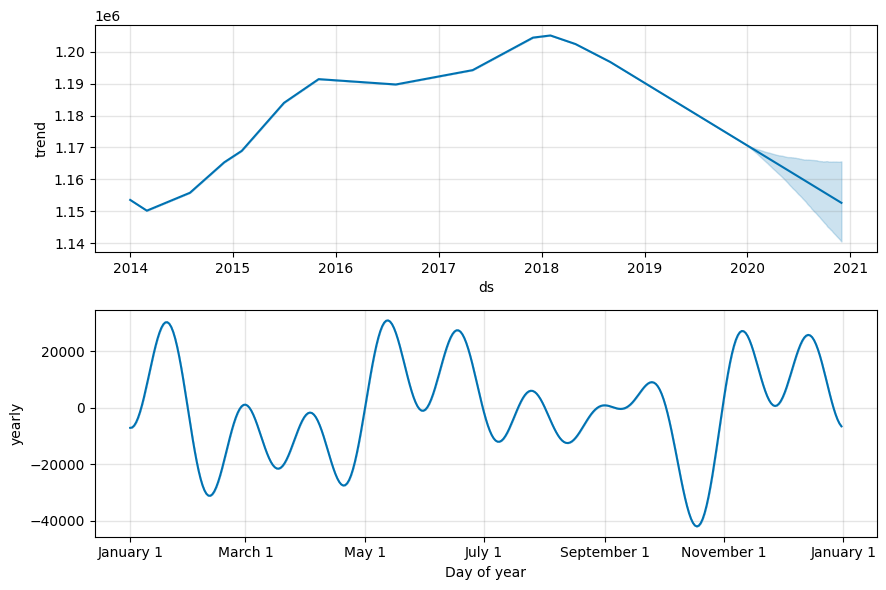

In [29]:
holidays = None  # Por ahora lo dejo en none

# Creo el modelo
model = Prophet(holidays=holidays)

# Ajusto el modelo a los datos
model.fit(data_prophet)

# Genero el futuro
future = model.make_future_dataframe(periods=365)  # Por ahora generamos 365 dias

# Hacemos la predicción
forecast = model.predict(future)

# Grafico la predicción
fig1 = model.plot(forecast)
plt.title('Forecasted Positions')
plt.xlabel('Date')
plt.ylabel('Positions')
plt.show()

# Grafico los componentes del modelo, como tenemos datos mensuales vamos a tener estacionalidad mensual y tendencia.
fig2 = model.plot_components(forecast)
plt.show()